# Person Segmentation for Deidentification Example

Segmentation models yield image masks that can be combined with simple image processing techniques to redact personally identifiable information in images.

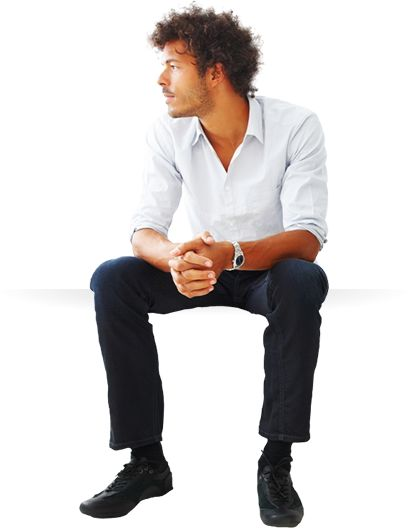

In [1]:
from IPython.display import Image
sample_img_url = 'https://i.pinimg.com/474x/de/89/8a/de898a67a2fa43ad29ad6cf80725d96a--people-sitting-person-sitting.jpg'
#sample_img_path = 'person-sitting.jpg'
img = Image(sample_img_url)
img

## Import Machine Learning and Image Processing Libraries

In [2]:
import os
import warnings; warnings.simplefilter('ignore')   # suppress warnings
import numpy as np
import tensorflow as tf
from PIL import Image as Im     # since we use Image from IPython.display
from PIL import ImageFilter
from io import BytesIO

## Set paths to model assets

In [3]:
# wget https://storage.googleapis.com/download.tensorflow.org/models/tflite/gpu/deeplabv3_257_mv_gpu.tflite -P ~/Downloads
model_path = os.environ['HOME'] + '/Downloads/'
model_file = model_path + 'deeplabv3_257_mv_gpu.tflite'    

## Load Model and Get Model Details

In [4]:
interpreter = tf.lite.Interpreter(model_file)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()     # Shows details on input tensor shape and type
output_details = interpreter.get_output_details()   #                 output tensor shape and type

## Load Image as Numpy Array

In [5]:
img_shape = input_details[0]['shape'][1:3][::-1]    # To reshape for model input requirements
im = Im.open(BytesIO(img.data))
orig_size = im.size                                 # So we can resize to orignal dims later

img = im.resize(img_shape)

im = np.array(img)[np.newaxis] / 255                # Don't forget Normalization
im = im.astype(input_details[0]['dtype'])           # Caste as the type expected by the model

## Run Inference

In [6]:
interpreter.set_tensor(input_details[0]['index'], im)
interpreter.invoke()
results = output_details[0]['index']
res = interpreter.get_tensor(results)

In [7]:
res = np.argmax(res, axis=3)[0]                     # Argmax on axis=3 to determine pixel indices
res = 255 * (res!=15).astype(np.uint8)              # 'Person' class corresponds to index 15

## Process Image with Segmentation Mask

In [8]:
img = img.resize(orig_size)                         # restore image to original dimensions
blur = img.filter(ImageFilter.GaussianBlur(3))      # make a blurred copy
mask = Im.fromarray(res)
mask = mask.resize(img.size)
deanon = Im.composite(img, blur, mask)               # combine original & blurred with the binary segmentation mask

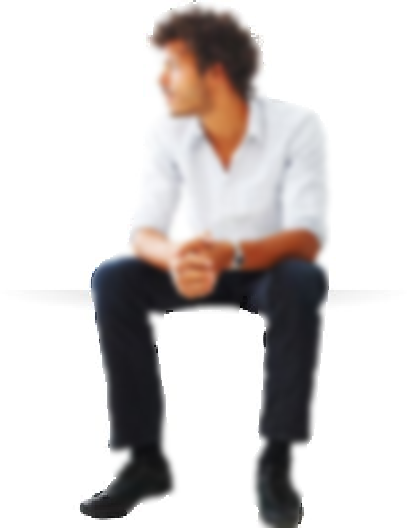

In [9]:
deanon